In [1]:
# imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import matplotlib as mpl

# Add the project root to Python path dynamically
# This finds the project root by looking for setup.py
current_dir = Path.cwd()
project_root = None

# Look for setup.py starting from current directory and going up
for parent in [current_dir] + list(current_dir.parents):
    if (parent / "setup.py").exists():
        project_root = parent
        break

if project_root is None:
    # Fallback: assume we're in src/example_files and go up 2 levels
    project_root = Path(__file__).parent.parent.parent if '__file__' in globals() else current_dir.parent.parent

sys.path.insert(0, str(project_root))

# Now we can import from src
from src.core_functionality.data_processing import DataProcessingCSV
from src.core_functionality.spectrum import Spectrum, Spectra
from src.core_functionality.baseline_correction import ARPLS
from src.core_functionality.chemometrics import Chemometrics, FIT_PARAMETERS, CONFIDENCE_INTERVALS
from src.core_functionality.phase import Phase
from src.core_functionality.rate_data import RateData
from src.core_functionality.baseline_correction import ARPLS

print(f"All imports successful! Project root: {project_root}")

All imports successful! Project root: c:\Users\alw7s\Git\PyMESpec


In [2]:
# Path to DRIFTS data
path = project_root / "src" / "example_files" / "CeO2_DRIFTS_Baseline_Correction" 


In [3]:
# Names of the CSV columns to read
# csv_frequency_column = "frequency"
# csv_intensity_column = "intensity"
# The initial and final rows to investigate (-1 means the last row with data)
csv_row_num_start = 1
csv_row_num_end = -1
# The spectral coordinate range to investigate (the subset of frequency values)
spectral_coordinate_start = 1250
spectral_coordinate_end = 3999
# Of all the data points collected this is the range of frames to investigate
starting_frame = 0
ending_frame = -1
# This is the number of data points collected per pulse in this experiment
# data_per_pulse = 800
max_iters = 80
lambda_parameter = 10**8
stop_ratio = 1e-8

print(f"Looking for data in: {path}")
print(f"Path exists: {path.exists()}")

Looking for data in: c:\Users\alw7s\Git\PyMESpec\src\example_files\CeO2_DRIFTS_Baseline_Correction
Path exists: True


In [4]:
data_processor = DataProcessingCSV(
    in_dir=path,
    # csv_frequency_column=csv_frequency_column,
    # csv_intensity_column=csv_intensity_column,
    csv_row_num_start=csv_row_num_start,
    csv_row_num_end=csv_row_num_end,
)

spectra = data_processor.get_spectra()

print(f" Number of spectra: {len(spectra)}")

 Number of spectra: 7


In [5]:
# Slice the section of the spectra that we actually want to investigate
spectra = spectra.isolate_spectra_sections([(spectral_coordinate_start, spectral_coordinate_end)])
# spectra = spectra[4:]

In [6]:
arpls = ARPLS()
package_spectra = arpls.baseline_corrected_spectra(spectra,lambda_parameter=lambda_parameter, stop_ratio=stop_ratio, max_iters=max_iters, full_output=False)



c:\Users\alw7s\Git\PyMESpec\src\core_functionality\baseline_correction.py:100: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))


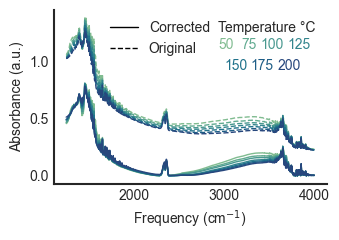

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_style("white")

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 10,
    "axes.linewidth": 1.5,
    "lines.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": False,
})

palette = sns.color_palette("crest", n_colors=len(spectra))
sns.set_palette(palette)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

temps = []
for i, spectrum in enumerate(spectra):
    color = palette[i]
    temp_val = (i + 2) * 25  # 50, 75, 100, 125, 150, 175, 200 ...

    ax.plot(
        package_spectra[i].frequencies,
        package_spectra[i].intensities,
        color=color,
        linestyle="-",
    )
    ax.plot(
        spectra[i].frequencies,
        spectra[i].intensities - 0.9,
        color=color,
        linestyle="--",
    )

    temps.append((temp_val, color))

ax.set_xlabel("Frequency (cm$^{-1}$)")
ax.set_ylabel("Absorbance (a.u.)")
sns.despine(ax=ax, top=True, right=True)

# small legend
solid = mpl.lines.Line2D([], [], linestyle='-', color='black', label='Corrected')
dashed = mpl.lines.Line2D([], [], linestyle='--', color='black', label='Original')
ax.legend(
    handles=[solid, dashed],
    loc="upper left",           # anchor corner
    bbox_to_anchor=(0.16, 1.01),# (x, y) in axes coords
    fontsize=10,
)


# =========================
# temp block (4 on top, rest below)
# =========================
ANCHOR_X = 0.63      # base x for first (50)
TOP_Y    = 0.8      # y for top row
ROW_GAP  = 0.12      # vertical gap
COL_GAP  = 0.085     # base horizontal spacing
ROW2_X_OFFSET = 0.02 # start of 2nd row
FONT_SZ  = 10
TOP_ROW_MAX = 4

# center the title over the 4 top items
ax.text(
    ANCHOR_X + .15,
    TOP_Y + 0.055,
    "Temperature °C",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=FONT_SZ,
)

# manual tiny x-offsets to make spacing *look* equal
# values are in axes coords — tweak 0.005 steps if you want
manual_dx = {
    50:   0.000,   # leave as is
    75:   0.000,   # leave as is
    100:  0.00,   # nudge right (3 digits)
    125:  0.012,   # a hair more
    150:  0.018,
    175:  0.028,
    200:  0.042,
}

for idx, (temp_val, color) in enumerate(temps):
    label = f"{temp_val}"
    dx = manual_dx.get(temp_val, 0.0)

    if idx < TOP_ROW_MAX:
        # top row: 50, 75, 100, 125
        x = ANCHOR_X + idx * COL_GAP + dx
        y = TOP_Y
    else:
        # bottom row: 150, 175, 200
        j = idx - TOP_ROW_MAX
        x = ANCHOR_X + ROW2_X_OFFSET + j * COL_GAP + dx
        y = TOP_Y - ROW_GAP

    ax.text(
        x,
        y,
        label,
        color=color,
        fontsize=FONT_SZ,
        ha="center",
        va="center",
        transform=ax.transAxes,
    )

fig.tight_layout()
plt.savefig("CeO2_DRIFTS_Baseline_Correction.png", dpi=800)
plt.show()


In [8]:
arpls = ARPLS()

package_spectra = arpls.baseline_corrected_spectra(spectra, lambda_parameter=lambda_parameter, stop_ratio=stop_ratio, max_iters=max_iters, full_output=False)
target_spectrum = spectra[0]
target_spectrum.intensities = target_spectrum.intensities - np.min(target_spectrum.intensities)
baseline = arpls.get_baseline(target_spectrum, lambda_parameter=lambda_parameter, stop_ratio=stop_ratio, max_iters=max_iters, full_output=False)
baseline_corrected_spectrum= arpls.baseline_corrected_spectrum(target_spectrum, lambda_parameter=lambda_parameter, stop_ratio=stop_ratio, max_iters=max_iters, full_output=False)


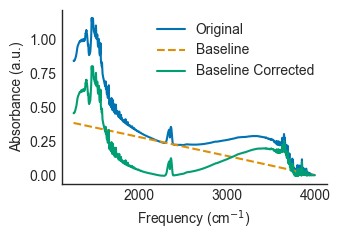

In [9]:

sns.set_style("white")
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 10,
    "axes.linewidth": 1.0,
    "lines.linewidth": 1.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": False,
})

palette = sns.color_palette("colorblind", 3)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(
    target_spectrum.frequencies,
    target_spectrum.intensities,
    label="Original",
    color=palette[0],
)

ax.plot(
    target_spectrum.frequencies,
    baseline,
    label="Baseline",
    color=palette[1],
    linestyle="--",
)

ax.plot(
    baseline_corrected_spectrum.frequencies,
    baseline_corrected_spectrum.intensities,
    label="Baseline Corrected",
    color=palette[2],
)

ax.set_xlabel("Frequency (cm$^{-1}$)")
ax.set_ylabel("Absorbance (a.u.)")

sns.despine(ax=ax, top=True, right=True)

ax.legend(loc="upper right", fontsize=10)

fig.tight_layout()
plt.savefig("CeO2_DRIFTS_Baseline_Correction_Example.png", dpi=800)
plt.show()


In [10]:
# We see that the baseline slightly deviates from a linear baseline. 

In [11]:
# If we now update the lambda parameter which controls the smoothness (flexibility) of the baseline fit
lambda_parameter = 10**4
package_spectra = arpls.baseline_corrected_spectra(spectra, lambda_parameter=lambda_parameter, stop_ratio=stop_ratio, max_iters=max_iters, full_output=False)
target_spectrum = spectra[1]
target_spectrum.intensities = target_spectrum.intensities - np.min(target_spectrum.intensities)
baseline = arpls.get_baseline(target_spectrum, lambda_parameter=lambda_parameter, stop_ratio=stop_ratio, max_iters=max_iters, full_output=False)
baseline_corrected_spectrum= arpls.baseline_corrected_spectrum(target_spectrum, lambda_parameter=lambda_parameter, stop_ratio=stop_ratio, max_iters=max_iters, full_output=False)


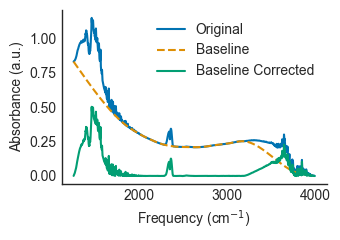

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# --- match style ---
sns.set_style("white")
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 10,
    "axes.linewidth": 1.0,
    "lines.linewidth": 1.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": False,
})

# 3 nice colors (can be anything)
palette = sns.color_palette("colorblind", 3)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(
    target_spectrum.frequencies,
    target_spectrum.intensities,
    label="Original",
    color=palette[0],
)

ax.plot(
    target_spectrum.frequencies,
    baseline,
    label="Baseline",
    color=palette[1],
    linestyle="--",
)

ax.plot(
    baseline_corrected_spectrum.frequencies,
    baseline_corrected_spectrum.intensities,
    label="Baseline Corrected",
    color=palette[2],
)

ax.set_xlabel("Frequency (cm$^{-1}$)")
ax.set_ylabel("Absorbance (a.u.)")

sns.despine(ax=ax, top=True, right=True)

ax.legend(loc="upper right", fontsize=10)

fig.tight_layout()
plt.show()


In [13]:
# We now see that our baseline fits much closer to the overall form of the spectrum.